## IMDb

In [1]:
from fastai.text import *
import html

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('..')/'data/imdb/aclImdb/'

## Standardize format

In [3]:
CLAS_PATH=Path('..')/'data/imdb/imdb_clas'
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('..')/'data/imdb/imdb_lm/'
LM_PATH.mkdir(exist_ok=True)

In [4]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

In [5]:
len(trn_texts),len(val_texts)

(75000, 25000)

In [6]:
col_names = ['labels','text']

In [7]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [8]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

#clip data - temp only
trn_texts = trn_texts[:1500]
trn_labels = trn_labels[:1500]
val_texts = val_texts[:500]
val_labels = val_labels[:500]

In [9]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [10]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [11]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [12]:
len(trn_texts), len(val_texts)

(1800, 200)

In [13]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language model tokens

In [14]:
chunksize=24000

In [15]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [16]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [17]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [18]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [19]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [20]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [21]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [22]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [23]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 24600),
 (',', 20571),
 ('.', 20256),
 ('and', 11984),
 ('a', 11770),
 ('of', 10546),
 ('to', 9625),
 ('is', 7989),
 ('it', 6886),
 ('in', 6873),
 ('i', 6244),
 ('this', 5585),
 ('that', 5322),
 ('"', 4776),
 ("'s", 4382),
 ('-', 3780),
 ('was', 3714),
 ('\n\n', 3625),
 ('as', 3375),
 ('for', 3242),
 ('with', 3226),
 ('movie', 3215),
 ('but', 3088),
 ('film', 2914),
 (')', 2601)]

In [24]:
max_vocab = 60000
min_freq = 2

In [25]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [26]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

9870

In [27]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [28]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [29]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [30]:
vs=len(itos)
vs,len(trn_lm)

(9870, 1800)

Previously in lesson 4, we trained a language model that was state of the art. Using a pre-selected text articles from wikipedia, a language model was trained, and the weights were saved.

## wikitext103 conversion


How to use a pretrained model - must have same network sizes

    em_sz - embedding sizes for vectors (400)
    nh - number of hidden (# of activations)

    nl - number of layers (hidden)

    model type: AWD LSTM link

Some work will have to be done to map the pre-trained vocabulary to the current vocab that we are working with. Any words not found in pre-trained vocab, we will use global mean values.


In [31]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

In [32]:
em_sz,nh,nl = 400,1150,3

In [33]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [34]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [35]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [36]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [37]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [38]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))


Language Model Creation

    wd - weight decay
    bptt - back prop through time
    bs - batchsize

We will be performing a continuous process of

    given words --> predict next word

Lesson 4 - note the best loss

[ 0.      4.3926  4.2917]                                       
[ 1.       4.37693  4.28255]                                  
[ 2.       4.37998  4.27243]                                  
[ 3.       4.34284  4.24789]                                  
[ 4.      4.3287  4.2317]                                     
[ 5.       4.28881  4.20722]                                  
[ 6.       4.24637  4.18926]                                  
[ 7.       4.23797  4.17644]  


Pretrained Model - we already start with a better score

epoch      trn_loss   val_loss   accuracy                     
    0      4.332359   4.120674   0.289563  
    1      4.247177   4.067932   0.294281 


Comparison to Word2Vec

Word2Vec - single embedding matrix. Each word has a matrix and thats it. It's a single layer (input) from a pretrained model. It's from a linear model on a co-occurance matrix.


## Language model

In [39]:
wd=1e-7
bptt=70
bs=24
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [40]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

![title](img/fastai_nlp_flowchart.png)

![title](img/fastai_rnn_encoder.png)

In [41]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [42]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

In [43]:
learner.model.load_state_dict(wgts)

In [44]:
lr=1e-3
lrs = lr

In [45]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      4.525618   4.217538   0.252971  



[4.217537677688668, 0.2529707835897546]

In [46]:
learner.save('lm_last_ft')

In [47]:
learner.load('lm_last_ft')

In [48]:
learner.unfreeze()

In [49]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy   
    0      4.72608    4.553224   0.217831  



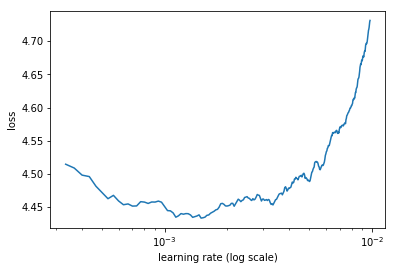

In [50]:
learner.sched.plot()

In [51]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

epoch      trn_loss   val_loss   accuracy   
    0      4.395126   4.125221   0.257677  
    1      4.118204   4.087892   0.262774  
    2      3.950158   4.083437   0.26404   



[4.083436635816022, 0.26404026562820015]

In [52]:
learner.save('lm1')

In [53]:
learner.save_encoder('lm1_enc')

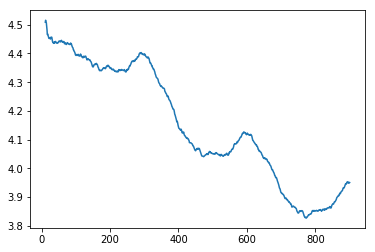

In [54]:
learner.sched.plot_loss()

![title](img/ds_size_acc_all.png)

![title](img/ds_size_acc_logx_all.png)

![title](img/ds_size_acc_wiki.png)

![title](img/ds_size_acc_logx_wiki.png)

## Classifier tokens

In [55]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [56]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [57]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [58]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [59]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

9870

In [60]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [61]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [62]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [63]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [64]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 24

In [65]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [66]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [67]:
# part 1
#dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [68]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [69]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [70]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [71]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [72]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [73]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [74]:
#wd = 1e-7
#wd = 0
#learn.load_encoder('lm2_enc')

In [75]:
learn.freeze_to(-1)

 88%|████████▊ | 37/42 [00:09<00:01,  3.98it/s, loss=3.03]


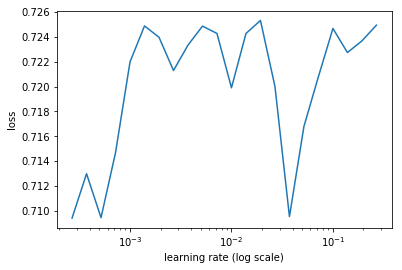

In [76]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [77]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      0.725816   0.693867   0.492979  



[0.693867098902124, 0.49297858122840943]

In [78]:
learn.save('clas_0')

In [79]:
learn.load('clas_0')

In [80]:
learn.freeze_to(-2)

In [81]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      0.693636   0.691859   0.53107   



[0.6918591121210151, 0.5310696127232778]

In [82]:
learn.save('clas_1')

In [83]:
learn.load('clas_1')

In [84]:
learn.unfreeze()

In [85]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy   
    0      0.702519   0.694414   0.507021  
    1      0.695492   1.670095   0.492979  
    2      0.688011   0.68457    0.540092  
    3      0.663119   0.671603   0.576013  
    4      0.605328   0.68822    0.581845  
    5      0.517177   1.557227   0.498293  
    6      0.422777   1.030361   0.607221  
    7      0.325512   0.971676   0.58877   
    8      0.281107   0.776298   0.650353  
    9      0.204724   0.786017   0.674039  
    10     0.181681   1.758568   0.591414  
    11     0.165406   0.897973   0.662194  
    12     0.147524   0.815911   0.675739  
    13     0.125176   0.848117   0.688023  



[0.8481166515197142, 0.6880227583479211]

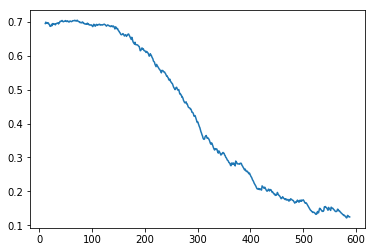

In [86]:
learn.sched.plot_loss()

In [87]:
learn.save('clas_2')

The previous state of the art result was 94.1% accuracy (5.9% error). With bidir we get 95.4% accuracy (4.6% error).

## Fin

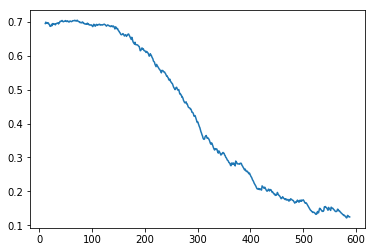

In [88]:
learn.sched.plot_loss()